## NCA Maze Solver

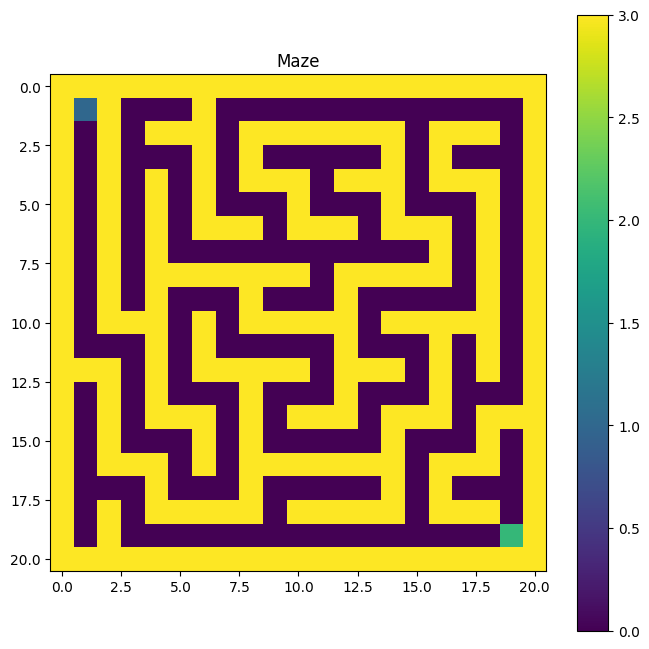

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_maze(size):
    """
    Generates a random maze using Depth-First Search (DFS) algorithm.
    0 - empty cell
    3 - wall/obstacle
    """
    maze = np.ones((size, size), dtype=int) * 3  # Initialize maze with walls

    def carve_path(x, y):
        directions = [(0, 2), (0, -2), (2, 0), (-2, 0)]
        np.random.shuffle(directions)
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 1 <= nx < size-1 and 1 <= ny < size-1 and maze[nx, ny] == 3:
                maze[nx, ny] = 0  # Carve path
                maze[x + dx//2, y + dy//2] = 0  # Remove wall
                carve_path(nx, ny)

    # Start carving
    start_x, start_y = 1, 1
    maze[start_x, start_y] = 0
    carve_path(start_x, start_y)

    # Add start (1) and target (2)
    maze[1, 1] = 1  # Start
    maze[-2, -2] = 2  # Target
    return maze

def display_maze(maze):
    plt.figure(figsize=(8, 8))
    plt.imshow(maze, cmap="viridis", interpolation="none")
    plt.colorbar()
    plt.title("Maze")
    plt.show()

# Generate and display a maze
maze_size = 21  # Odd numbers only
maze = generate_maze(maze_size)
display_maze(maze)


In [2]:
import torch
import torch.nn as nn

class MazeSolverNCA(nn.Module):
    def __init__(self, state_dim=4, hidden_dim=32):
        super(MazeSolverNCA, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(state_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, state_dim, kernel_size=1)
        )

    def forward(self, x):
        # Local update rule
        dx = self.conv(x)
        return torch.clamp(x + dx, 0, 1)  # Clamp states between 0 and 1


In [3]:
def preprocess_maze(maze, state_dim=4):
    """
    Convert the maze into a one-hot encoded state tensor:
    - 0: Empty
    - 1: Start
    - 2: Target
    - 3: Wall
    """
    maze_onehot = np.eye(state_dim)[maze]
    maze_onehot = maze_onehot.transpose(2, 0, 1)  # Channels first
    return torch.tensor(maze_onehot, dtype=torch.float32).unsqueeze(0)  # Add batch dim


In [4]:
def train_nca(model, maze, target_steps=50, epochs=500, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    maze_input = preprocess_maze(maze)
    start_state = maze_input.clone()

    loss_history = []

    for epoch in range(epochs):
        state = start_state.clone()

        for step in range(target_steps):
            state = model(state)

        # Loss: encourage activation of the target location (state 2)
        target_mask = (maze == 2).astype(np.float32)
        target_tensor = torch.tensor(target_mask, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

        loss = torch.nn.functional.mse_loss(state[:, 1, :, :], target_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    return loss_history, state


C:\Users\ernan\AppData\Local\Temp\ipykernel_1960\4215718724.py:18: UserWarning: Using a target size (torch.Size([1, 1, 21, 21])) that is different to the input size (torch.Size([1, 21, 21])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(state[:, 1, :, :], target_tensor)


Epoch 0, Loss: 0.0023
Epoch 50, Loss: 0.0023
Epoch 100, Loss: 0.0023
Epoch 150, Loss: 0.0023
Epoch 200, Loss: 0.0023
Epoch 250, Loss: 0.0023
Epoch 300, Loss: 0.0023
Epoch 350, Loss: 0.0023
Epoch 400, Loss: 0.0023
Epoch 450, Loss: 0.0023


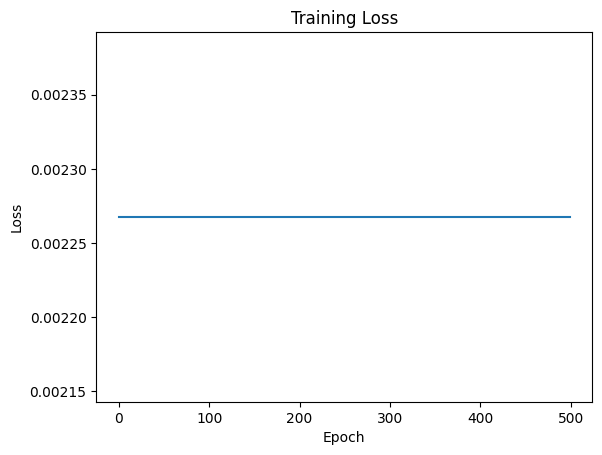

In [5]:
nca = MazeSolverNCA()
loss_history, final_state = train_nca(nca, maze)

# Plot loss
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


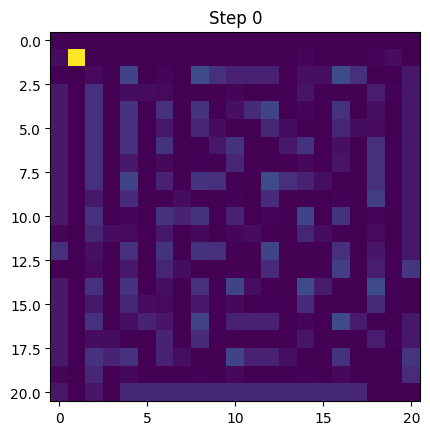

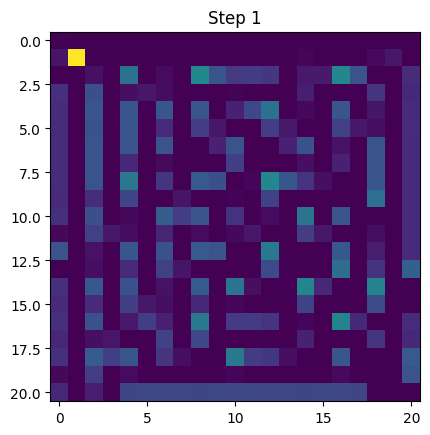

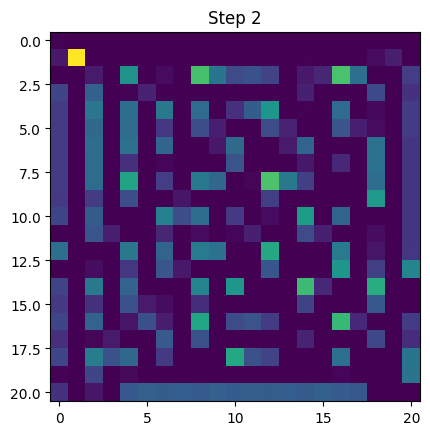

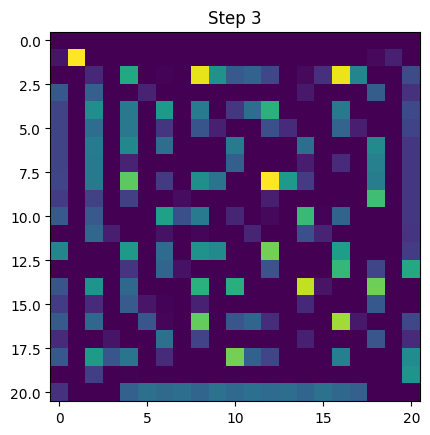

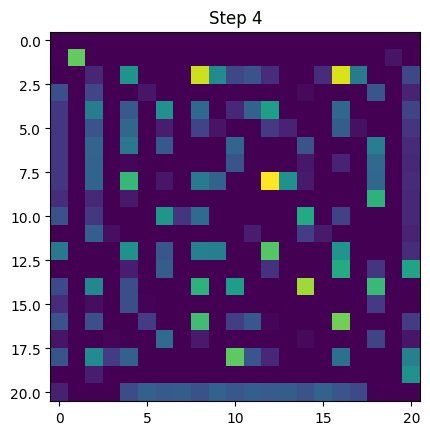

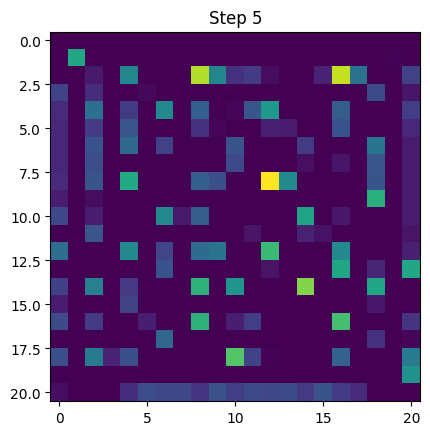

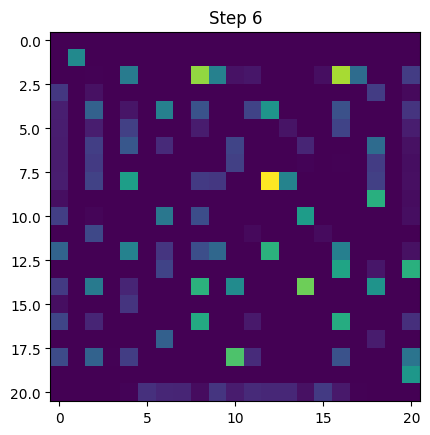

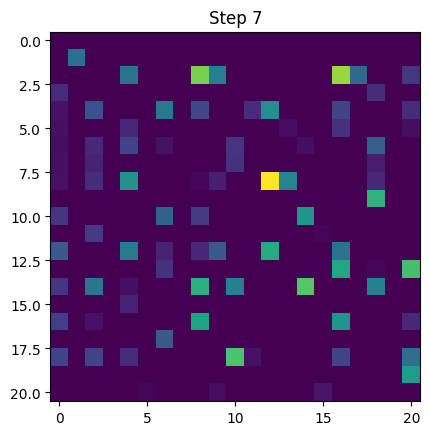

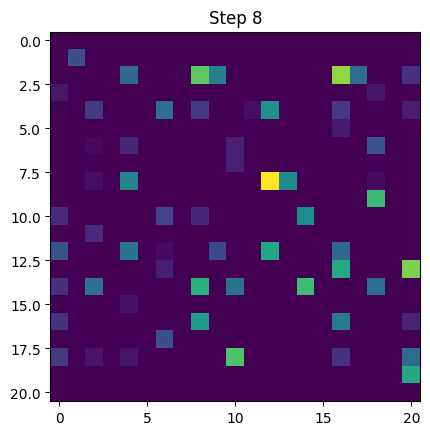

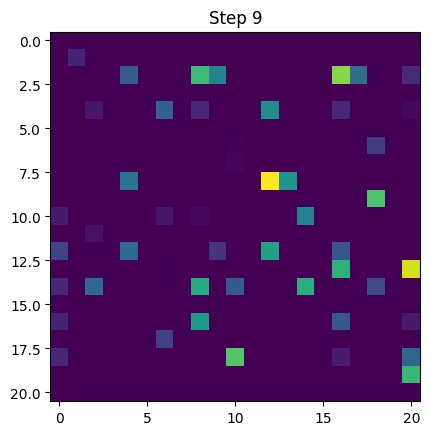

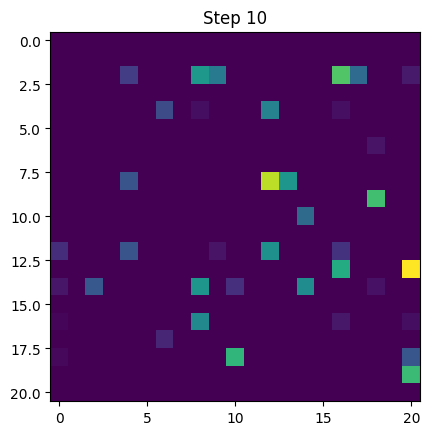

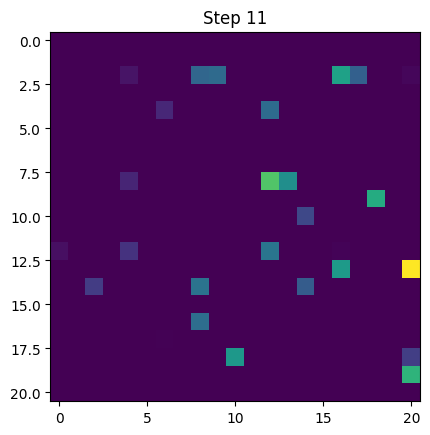

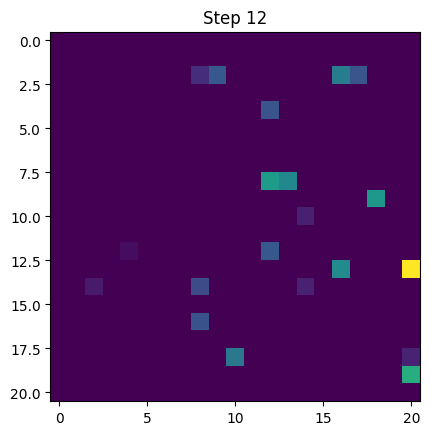

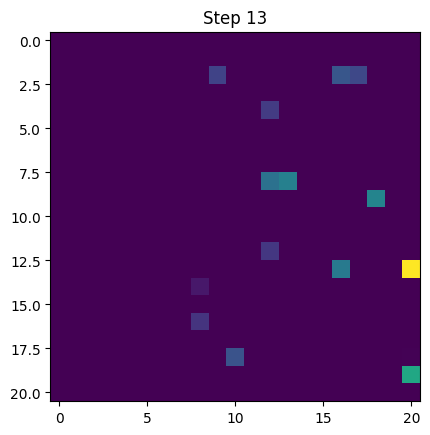

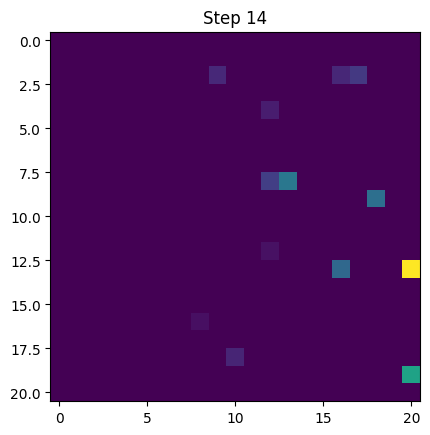

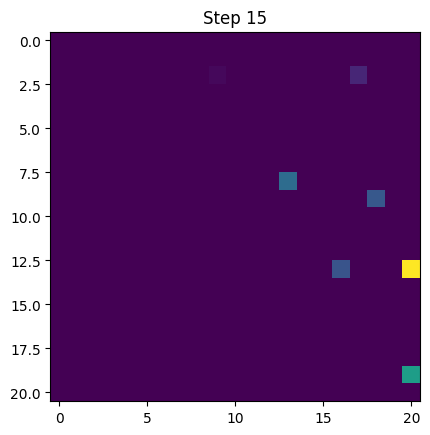

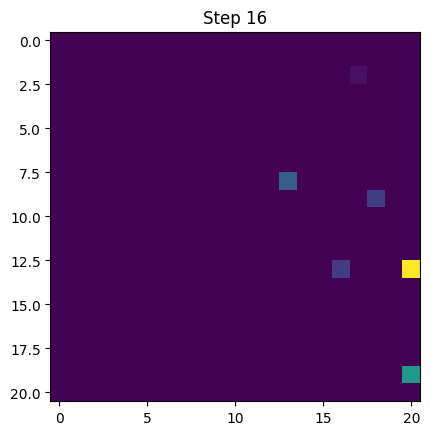

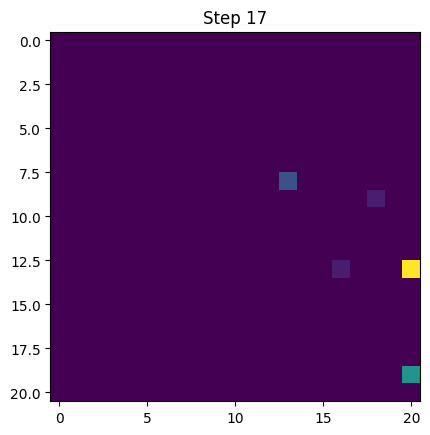

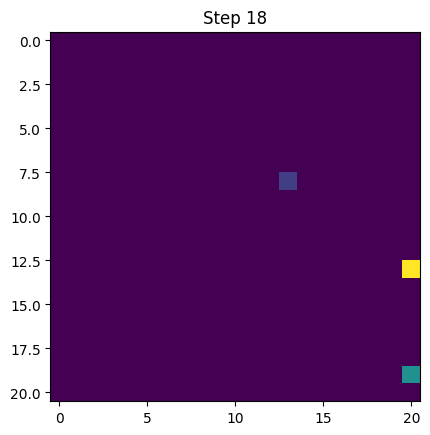

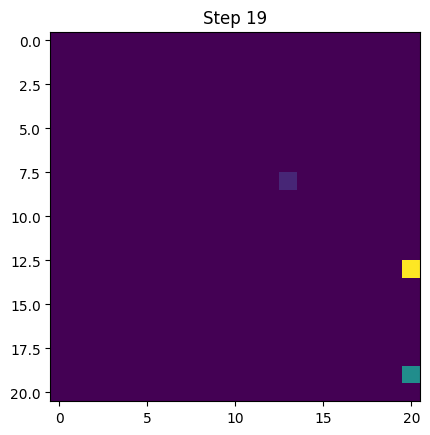

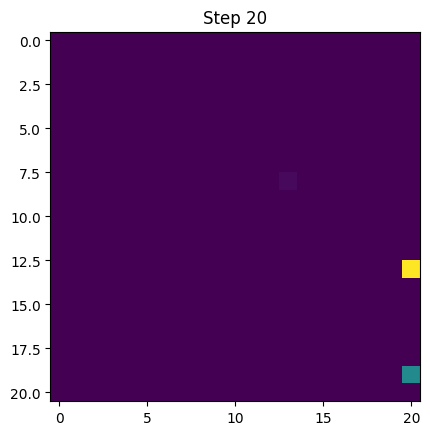

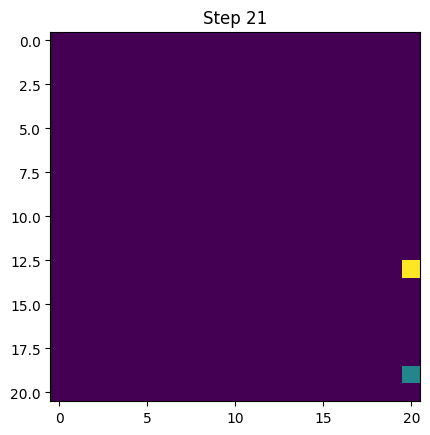

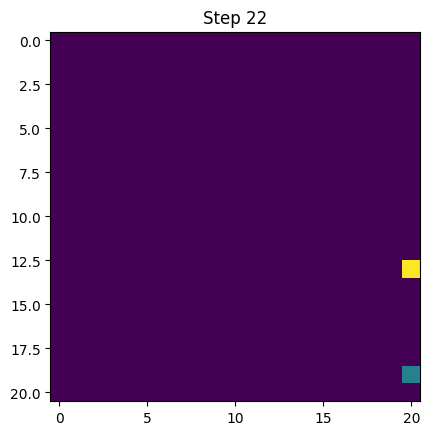

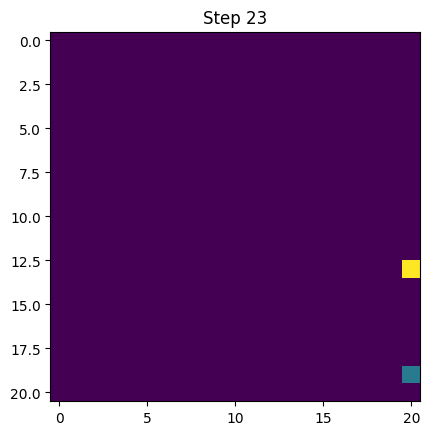

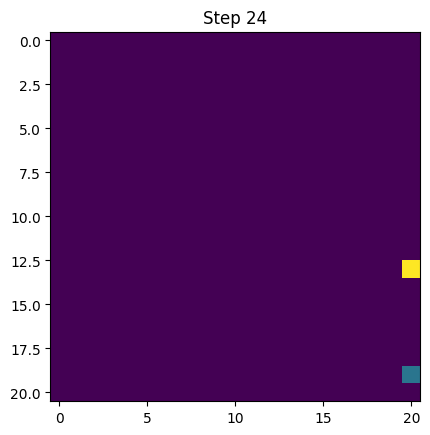

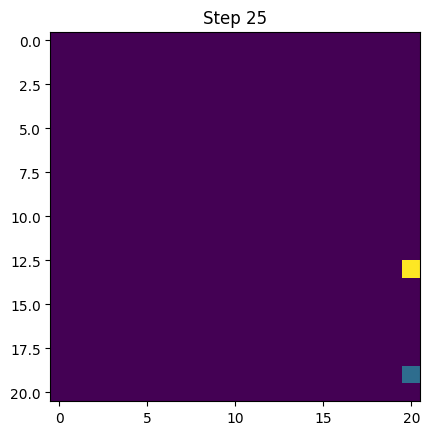

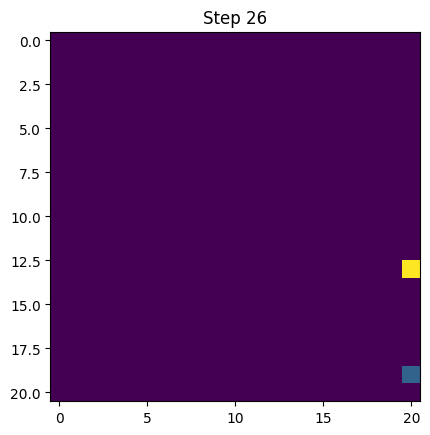

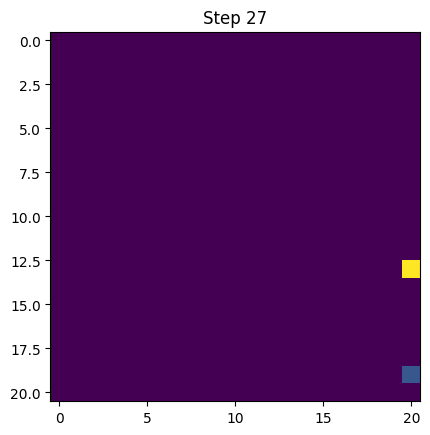

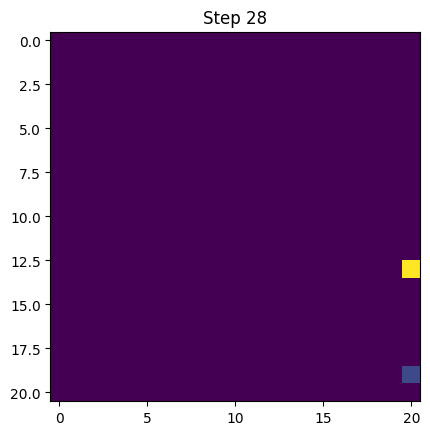

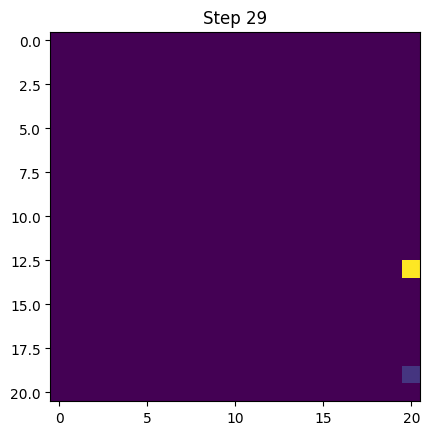

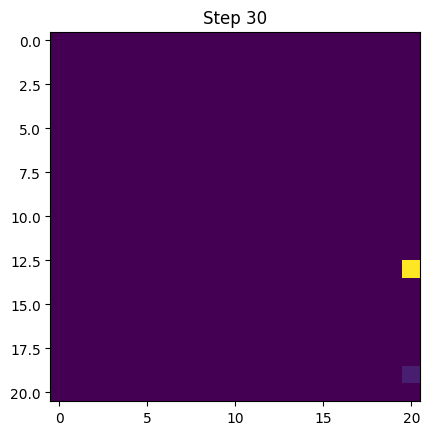

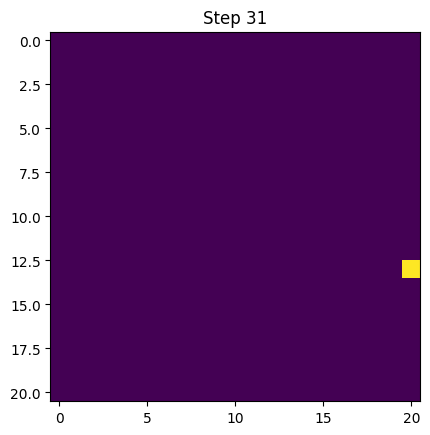

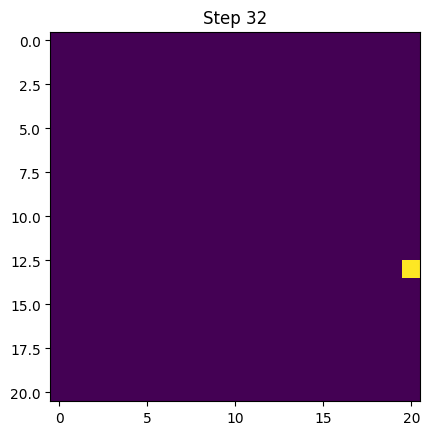

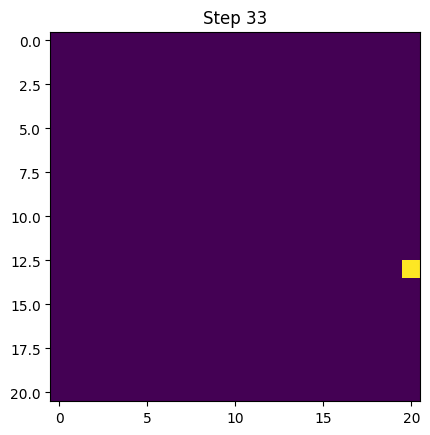

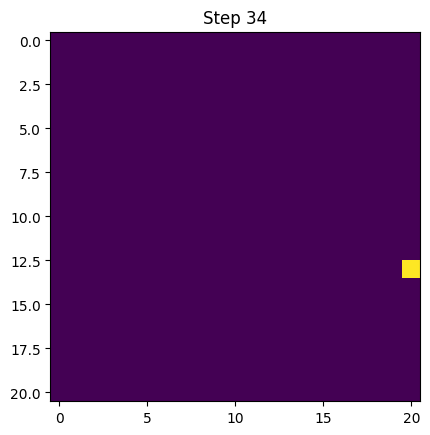

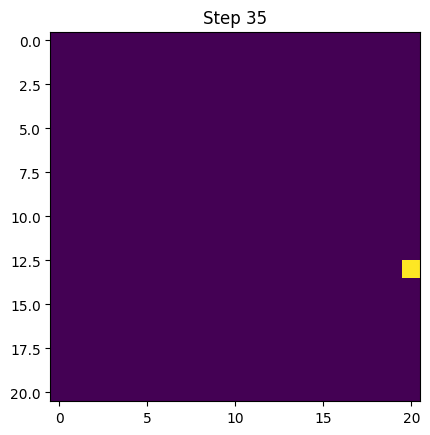

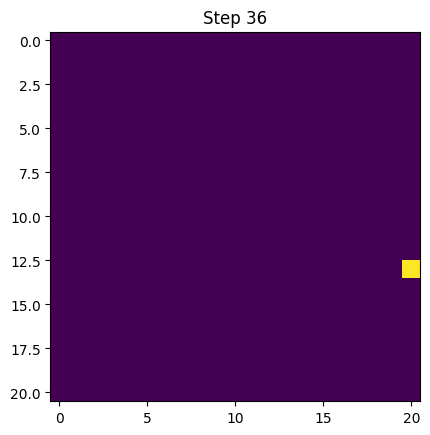

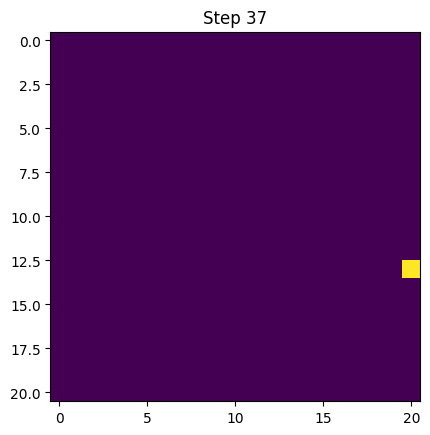

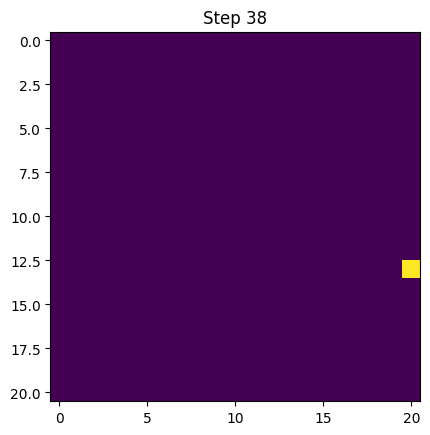

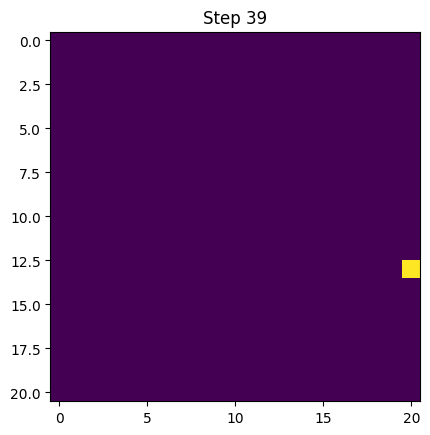

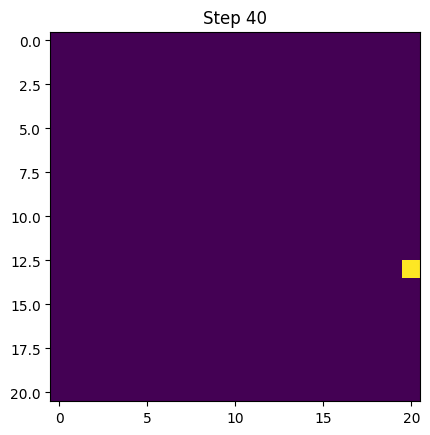

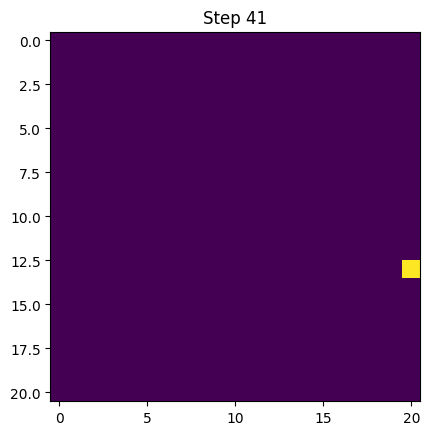

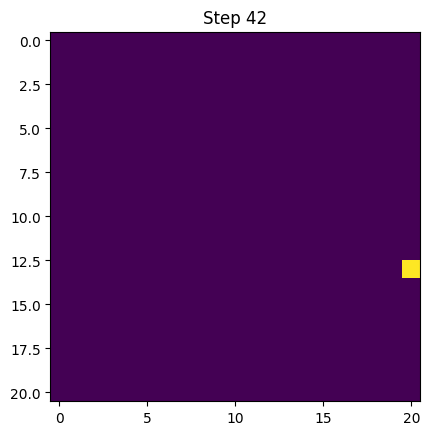

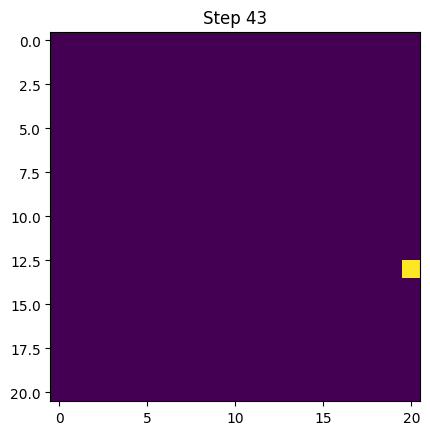

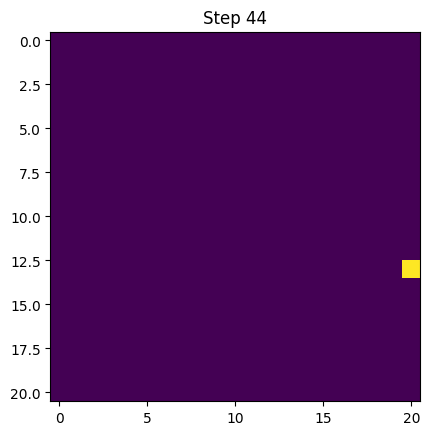

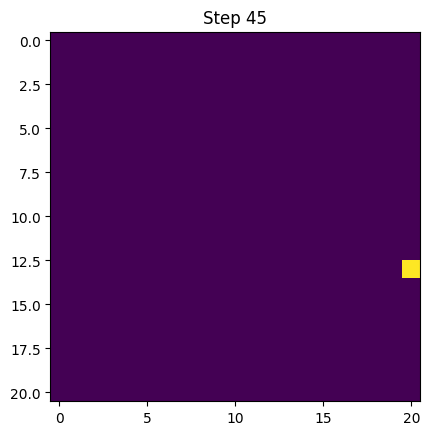

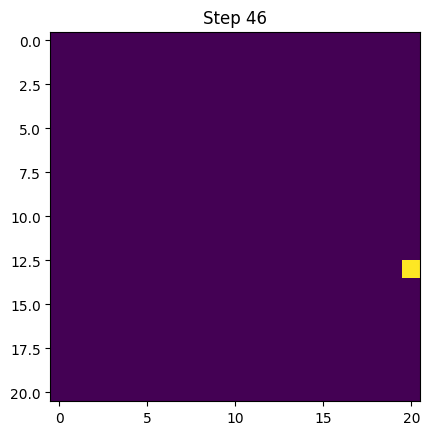

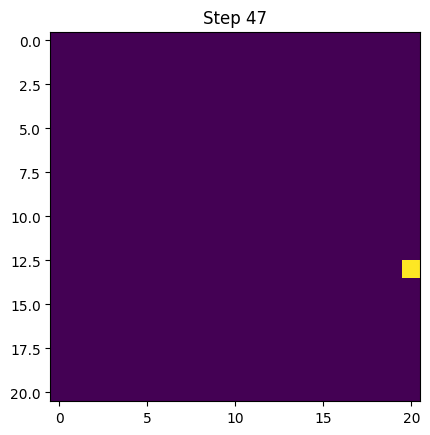

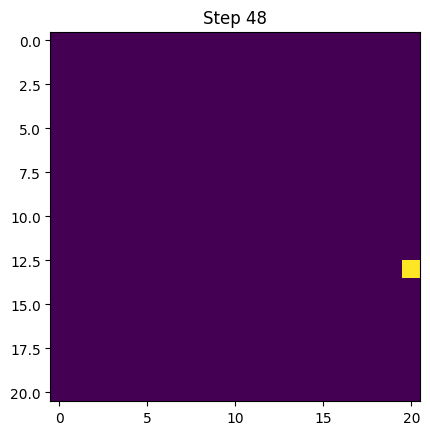

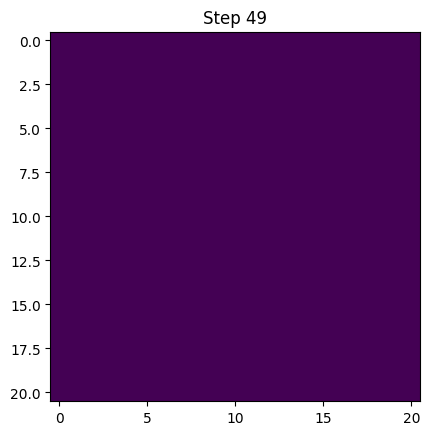

In [6]:
def test_nca(model, maze, steps=50):
    state = preprocess_maze(maze)
    for step in range(steps):
        state = model(state)
        grid_state = state[0, 1].detach().numpy()  # Channel corresponding to the path
        plt.imshow(grid_state, cmap="viridis")
        plt.title(f"Step {step}")
        plt.pause(0.1)

    plt.show()

# Test the trained NCA
test_nca(nca, maze)
